In [3]:
import matplotlib.pyplot as plt

In [8]:
### Genetic algorithm to fit a regression line of the form y=ax+b to a 2-variable dataset

import random
import numpy as np

# load the data
my_data_file = 'temp_data.npy'
data = np.load(my_data_file)
data = data[:]

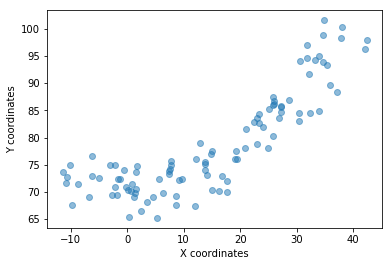

In [17]:
column1 = data[:,0]
column2 = data[:,1]

plt.xlabel('X coordinates')
plt.ylabel('Y coordinates')
plt.scatter(column1,column2,alpha=0.5)
plt.show()

In [18]:
# scipy regression function to compare with the genetic algorithm's solutions
from scipy import stats
print(stats.linregress(data)[0:2])

(0.53992593932107447, 70.709972206845848)


In [40]:
# parameters
initial_pop_size = 200
mutation_rate = 0.05
num_generations = 30
chromosome_length = 2
num_survivors = 50 

# functions

def A(): 

    '''
This function generates a population of solutions as a two dimensional array with dimensions population size (100) and chromosome length (2).
It first uses numpy linspace to return a 5000 sample 1-D array of evenly spaced numbers over the interval (-1,80) 
In order to maintain diversity, the function then generates a random sample from the elements of the gene pool array.
It accomplishes this without replacement and outputs an array of 100 rows and 2 columns
There are no inputs for this function.
    '''
    gene_pool = np.linspace(-1,80,num = 5000)
    dimensions = (initial_pop_size, chromosome_length) #100 pairs of a and b values for y=mx+b 
    return (np.random.choice(gene_pool, size=dimensions, replace=False)) 

def B(coefficients):

    '''
This function calculates the mean sum of squared errors for each chromosome. It is the set up for our fitness function.
At first, we compute the length of our dataset array and we initialize a tot variable, setting it to 0
Then we calculate the difference between the observed value of y and the predicted value of y for our best fit line (using the values of a,b in our chromosome), which is essentially the error 
We return the mean sum of the squared distances from the points to the best fit line. This is the quantity that we are trying to minimize.
    '''
    k = len(data)
    tot = 0
    for j in range(k):
        y = coefficients[0] * data[j,0] + coefficients[1] #calculating the regression line from the coefficients
        res = data[j,1] - y #for each element, we're calcuting the squared error 
        tot += res**2
    return tot/k #SSE
    
def C():
 
    '''
This is the fitness function for the genetic algorithm. We use it to determine the fitness value for each chromosome, i.e. each pair of (a,b) for our best fit line. 
We call function B to calculate the mean SSE of our predicted values of y for each solution and store the fitness score in a list 
Finally, we convert the list into a numpy array.
    '''
    fitlist = []
    for x in range(len(current_pop)):
        fitlist.append(np.array([x,B(current_pop[x])])) #for each element in the current population, i'm evaluating the fitness score
    return np.array(fitlist)
    
def D():  
    '''
This function selects the parent solution in anticipation of reproduction. 
It returns the chromosome (a,b) which gives the least mean SSE out of a randomly selected sample of 25 chromosomes from the fitness_vector matrix.
At first, we are randomly selecting the indexes of 25 parents and using argmin to find which parent yields the least value for our sum of squared error. 
Then, we find the chromosome from our current population using the index. 
    '''
    random_selection = np.random.choice(range(len(fitness_vector)), num_survivors//2, replace=False) #generates 25 random integers, each within range of 0 and 100 and stores it in an array. Here, we invoke the choice function to randomly select the index positions 
    best = np.argmin(fitness_vector[random_selection,1])  #here, we are selecting the elements from the 25 indexes we previously generated from column 1 which is where we have the mean sse values. We invoke the argmin function to compare the index values from the fitness vector and return the index of the minimum mean sse along an axis
     #index of the list of indexes randomly selected [in the random selection array]
    best_index = random_selection[best] #this is the index of random_selection in which the index of the minimum mean sse in the fitness vector is stored
    return current_pop[int(fitness_vector[best_index][0])]  #corresponding chromosome is returned 

def E(): 
    ''' 
This is the crossover function.
We are first creating a numpy array with the dimensions (200,2) and populating with 0's.
Then, we are making 4 copies of our parent chromosomes which were previously generated by our fitness function.
The input is our population of 50 parents who have been selected by our fitness function.
At first, we take column 0 of the parental chromosome rows i.e. the gradient of the best fit line and append it to our duplicate_survivors array. Then, by using a permutation function, we randomly switch the order of the gradient values.
Then, we repeat the same process for column 1 of all parental chromosome rows i.e. the y-intercepts of the best fit line. We add it to our duplicate_survivors array and switch the order similarly through a permutation function.
The output is an offspring of reordered pair of gradients and y intercepts. 
    '''

    #copied the offsprings 4 times, which yields different kind of mutation 
    duplicate_size = len(new_population) - len(survivors) #200
    duplicate_survivors = np.zeros((duplicate_size, chromosome_length))
    for x in range(chromosome_length): # for each column in the survivor array
        duplicate_survivors[:, x] = np.repeat(survivors[:, x], 4, axis=0) # duplicate column 4 times, increasing copies of offspring leads to greater diversity upon crossing over and mutation 
        duplicate_survivors[:, x] = np.random.permutation(duplicate_survivors[:, x]) #crossing over each offsprig using permutation  
    return duplicate_survivors

def F(array):  

    '''
This is the mutation function, 
which is applied to maintain and introduce diversity in the genetic population and is usually applied with a low probability, so that our algorithm is not reduced to a random search.
Since the algorithm tends to converge to a specific point in the search space, mutation does its best to avoid convergence and explore more solutions to ensure global optimality.
However, it should be confined to a low value range as the larger the mutation rate, the more the convergence time.
Our function use a 5% probability for mutation. 
It first uses linspace to generate evenly spaced values between -1 and 1 and randomly selects one.
We then use random.random() to generate a random float uniformly in the semi-open range [0.0, 1.0).
Later, we add our randomly selected number to each element using a 5% probability. 
Note that generating a number between [-1, 1) means that we will have random additions and subtractions from our chromosome.    
    '''

    for i in array:
        for j in i:
            x = random.choice(np.linspace(-1,1,20))
            if mutation_rate>random.random():
                j = x + j                

    return array

########################################################################
# Start of main program
current_pop = A() #initialize a population of possible solutions of shape (100,2)
new_population = np.zeros((num_survivors * 5, chromosome_length)) #creating a matrix of 0's of the shape number of survivors [250] and chromosome length

# main loop
for i in range(num_generations): #terminating condition is the number of generations 
    
    fitness_vector = C() #evaluate the fitness score into an array for each solution 
    survivors = np.zeros((num_survivors, chromosome_length)) #(50,2) survivors and populating with zeros 
    for n in range(len(survivors)):#for loop that runs for length of survivors [50]
        survivors[n] = D() #using a for loop to populate the zero matrix called survivors with randomly generated parents 
        #created an array of survivors which is the minimum in the randomly sampled set of parents' sse 
        #D randomly selects 25 blocks from the initial population and returns 1 chromosome with the least sse. This is repeated 50 times in order to populated the entire zero matrix of survivors 
        #a lot of times it's selecting the same solution because D is selecting samples with the same survivors [who already had the lowest sse in a previous run]
        #this is why in the visualization, we have overlapping points 
    new_population[:len(survivors)] = survivors #inserting our list of survivors generated by the for loop to the new_population list 
    new_population[len(survivors):] = E() #populating the remainder of our new_population list with the offspring from our crossover function 


    new_population = F(new_population) #a mutated version of the offspring 
    
    current_pop = new_population #get the population and repeat the genetic algorithm
    new_population = np.zeros((num_survivors * 5, chromosome_length))
    

fitness_vector = C()
best_solution = current_pop[np.argmin(fitness_vector[:,1])]

print("The best solution is", best_solution)
print("with error equal to approximately", B(best_solution))

The best solution is [  0.60412082  67.86377275]
with error equal to approximately 27.9549259891


**Write a paragraph to explain what the parameters at the top of the script are. By experimenting with varying parameter values, determine what values produce solutions that are closest to the actual solution most efficiently. Why do you think this is? [\~200 words]**


At first, we are initializing the size of our population. This is essentially a list of possible solutions i.e. possible values of a and b for our best fit line (y=ax+b) in the form of chromosomes. In this algorithm, the size of our population is the same as the length of our dataset. However, when we increase our population size (n=1000), our approximate error decreases on average. A likely reason is that larger populations provide a better representation of different variable combinations. Although a smaller population size yields quicker convergence speed, the algorithm might be more easily trapped in local optima since a small part of the search space is explored. Nevertheless, a smaller population size can be sufficient for smaller problems. Since we only have two variables, we can specify a population size of 10. From a trial and error process, n=50 appears an optimal size. 

The second parameter is the mutation rate i.e. how often the offsprings produced by a combinantion of the parent solutions is mutated. It's purpose is to introduce variability and reduce the likelihood of the population converging to a sub-optimal solution. A too small mutation rate may result to premature convergence (falling to a local optima instead of a global optima) whereas a too high mutation rate reduces the search ability of our algorithm to a simple random walk.  Our mutation rate is appropriate for this problem. Note that altering the initial size of population affects the error approximation largely, whereas the model is not as sensitive to very high values for the mutation rate.

The third parameter is the number of generations and it is initialized to 10. This is the number of times the algorithm will select individuals from the current population and modify them to form new populations. For our algorithm, this serves the purpose of a terminantion condition i.e. it is the maximum number of times our genetic algorithm will run. This is not optimal since a satisfactory solution may or may not have been reached.  

Then, we've initialized our chromosome length to 2. Chromosome length is just a proxy for size of solution space, so taking into account the size of the solution space will necessarily increase the accuracy of this proxy. For our problem, we want to find the gradient and the y-intercept for our best-fit line i.e. the (a,b) in y=ax+b that yields the sum of squared errors, therefore 2 is the appropriate value. 

Lastly, we've initialized the number of survivors for our genetic algorithm. This is essentially the number of solutions [parents] that will be selected for crossing over for each generation. 

**Write a paragraph that gives an overview of how this program solves the given task, and what the output represents. [\~200 words]**

We are provided with a 2-variable dataset and the problem we are trying to solve is to find the gradient and y-intercept of the best fit line. 

**Outline**

1. [Start] Generate random population of 100 chromosomes. (suitable values for a,b)
2. [Fitness] Evaluate the mean sum of squared error of each chromosome in the population.
3. [New population] Create a new population by repeating the following steps until the new population is complete.


    1. [Selection] Select two parent chromosomes from a population according to their fitness by randomly sampling 25 chromosomes at a time. (the better fitness, the bigger chance to be selected)
    2. [Crossover] Copy the parents 4 times (200 chromosomes) and use the permutation function to form offspring solutions. 
    3. [Mutation] With a mutation probability of 5%, mutate new offspring by randomly adding or subtracting from the chromosome. 
    4. [Accepting] Place new offspring in the new population. 
    
4. [Replace] Use new generated population for a further run of the algorithm.
5. [Terminating Condition] If the end condition (number of generations = 10) is satisfied, stop, and return the best solution in current population.
6. [Loop] Go to step 2.

The output is a numpy array with the x coordinate as the value of the gradient and the y coordinate as the y-intercept of the best fit line. The algorithm also provides a measure of the error i.e. the mean sum of squared error which expresses the discrepancy between the data and our regression model. 

**Optimize the code: There are many aspects of the code that could be improved. Choose one part of the code and describe in as much detail as possible a way in which it can be optimized. Then, implement your optimization. Be clear about what you are optimizing for and how your proposal accomplishes this.**


1) At present, our genetic algorithm (GA) runs for 10 generations. This is also the termination condition, making over-fitting less likely, since the more iterations which occur, the more feedback the GA will have from cross-validation information. However, if the algorithm has terminated due to a maximum number of generations, a satisfactory solution may or may not have been reached. Therefore, I would modify the terminating condition so that the algorithms stops working when it detects there is no change in the best fitness value for some time (given in seconds). 


2) The larger the population size, the more time required for each iteration. Larger populations do, however, provide a better representation of different variable combinations. One alternative to using a large population size is to use multiple replicate runs. However, this does not allow for interbreeding between potentially useful gene mixtures. Therefore, I would increase the population size and run the GA multiple times to watch for general trends. I would also specify the number of times the GA should be run using the specified parameters and concatenate the results of each cycle together so that they will appear in the results plots. 